# Visualizations for no-error-kafka CircleCI job runs locally in Docker.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import os
import numpy as np

In [2]:
def convert_mem_to_mib(s):
    """
    Convert memory usage string to MiB. For example,
    '512MiB / 2GiB' -> 512.0
    
    :param s: string like '512MiB / 2GiB'
    :return: memory usage in MiB as float
    """
    usage, _ = s.split("/")
    match = re.match(r"([0-9.]+)([KMG]iB)", usage.strip())
    if not match:
        return None
    
    value, unit = match.groups()
    value = float(value)

    if unit == "KiB":
        return value / 1024
    elif unit == "MiB":
        return value
    elif unit == "GiB":
        return value * 1024
    else:
        raise ValueError("Unknown unit: " + unit)

In [3]:
def create_png_visualization(df, path, timestamp):
    tick_positions = np.arange(0, df["elapsed_seconds"].max() + 1, 15)
    tick_labels = [f"{int(t//60):02d}:{int(t%60):02d}" for t in tick_positions]
    total_duration = df["elapsed_seconds"].max()

    last_x = df["elapsed_seconds"].iloc[-1]
    last_y = df["mem_usage_mib"].iloc[-1]

    peak_idx = df["mem_usage_mib"].idxmax()
    peak_x = df.loc[peak_idx, "elapsed_seconds"]
    peak_y = df.loc[peak_idx, "mem_usage_mib"]

    fig, ax = plt.subplots(figsize=(12, 6))

    mem_line, = ax.plot(
        df["elapsed_seconds"], df["mem_usage_mib"],
        label="Memory Usage (MiB)",
        color="tab:blue",
        zorder=2
    )

    ax.set_xticks(tick_positions)
    ax.set_xticklabels(tick_labels, rotation=25)

    ax.set_xlabel("Duration (MM:SS)")
    ax.set_ylabel("Memory Usage (MiB)", color="tab:blue")
    ax.tick_params(axis="y", labelcolor="tab:blue")

    ax.set_title(
        f"Memory & CPU Utilization of 'no-error-kafka' CircleCI Job Over Time [{timestamp}]"
    )

    ax2 = ax.twinx()
    cpu_line, = ax2.plot(
        df["elapsed_seconds"], df["cpu_perc"],
        label="CPU Usage (%)",
        color="tab:orange",
        linestyle="-",
        zorder=2
    )

    ax2.set_ylabel("CPU Usage (%)", color="tab:orange")
    ax2.tick_params(axis="y", labelcolor="tab:orange")
    ax2.set_ylim(0, max(100, df["cpu_perc"].max() * 1.1))

    ax.text(
        last_x,
        last_y - 0.05 * df["mem_usage_mib"].max(),
        f"Total Duration: {int(total_duration//60):02d}:{int(total_duration%60):02d}",
        fontsize=10,
        ha="right",
        va="top",
        bbox=dict(facecolor="white", alpha=0.9),
        zorder=5
    )

    ax.text(
        peak_x - 0.15 * df["elapsed_seconds"].max(),
        peak_y + 0.05 * df["mem_usage_mib"].max(),
        f"Peak memory usage: {peak_y:.0f} MiB",
        fontsize=10,
        ha="center",
        va="bottom",
        bbox=dict(facecolor="white", alpha=0.9),
        zorder=5
    )

    ax.spines["top"].set_visible(False)

    ax.set_xlim(0, df["elapsed_seconds"].max() * 1.02)
    ax.set_ylim(0, df["mem_usage_mib"].max() * 1.1)

    ax.grid(zorder=0)

    lines = [mem_line, cpu_line]
    labels = [line.get_label() for line in lines]
    ax.legend(lines, labels, loc="upper left")

    fig.text(
        0.5, 0.01,
        "Source: Local Docker run via 'circleci local execute no-error-kafka'",
        ha="center",
        va="bottom",
        color="gray",
        fontsize=9
    )

    plt.tight_layout(rect=(0, 0.03, 1, 1))
    plt.savefig(path, dpi=300)
    plt.show()

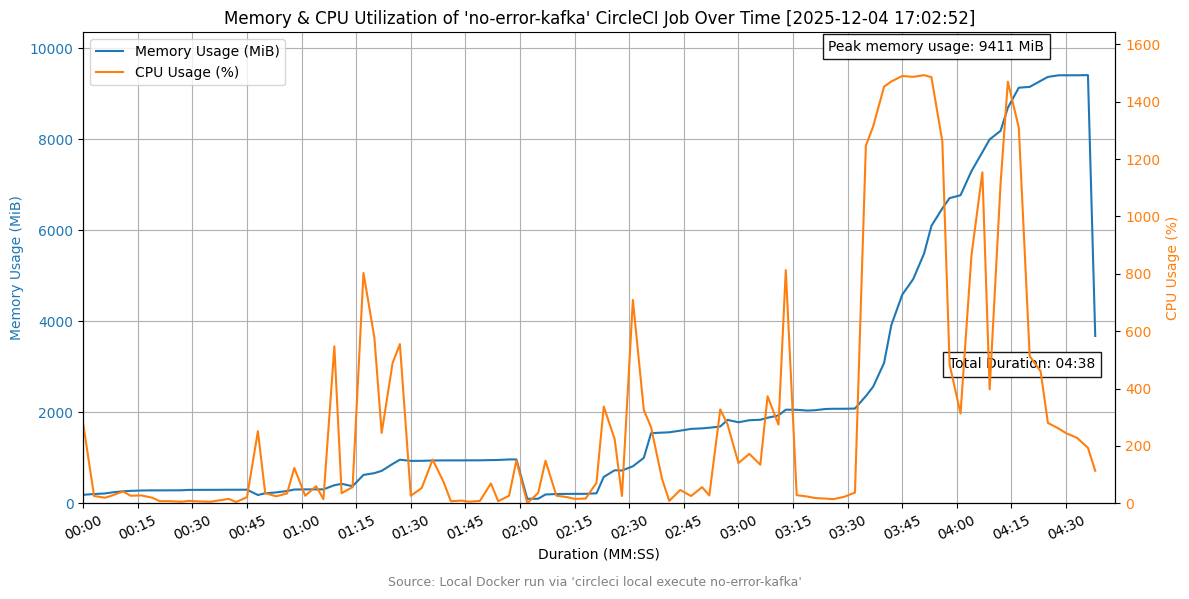

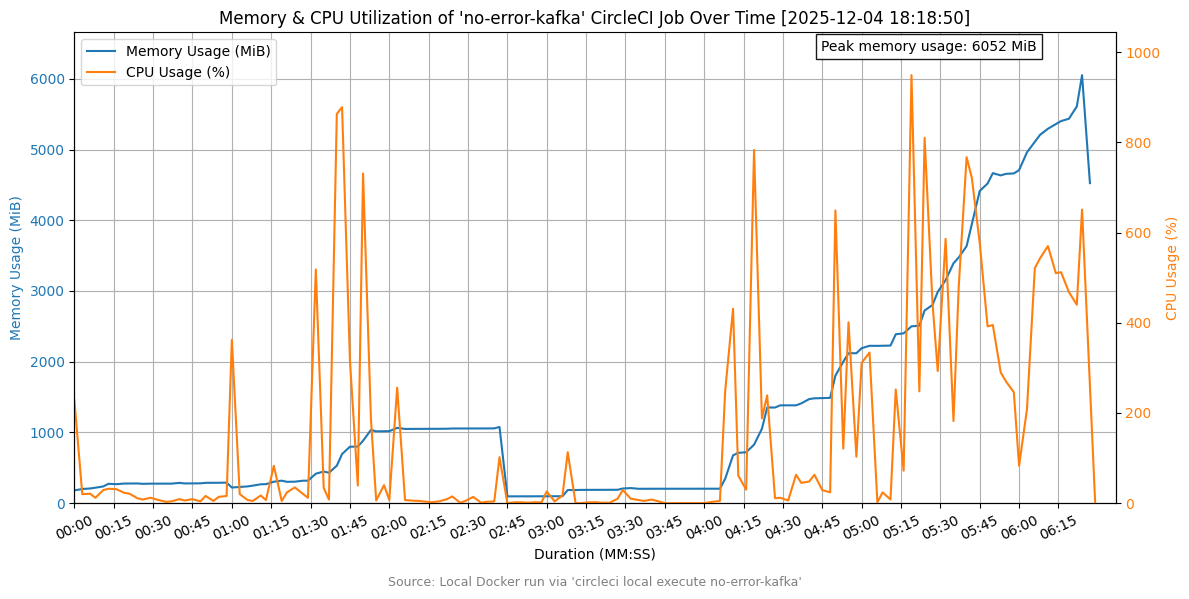

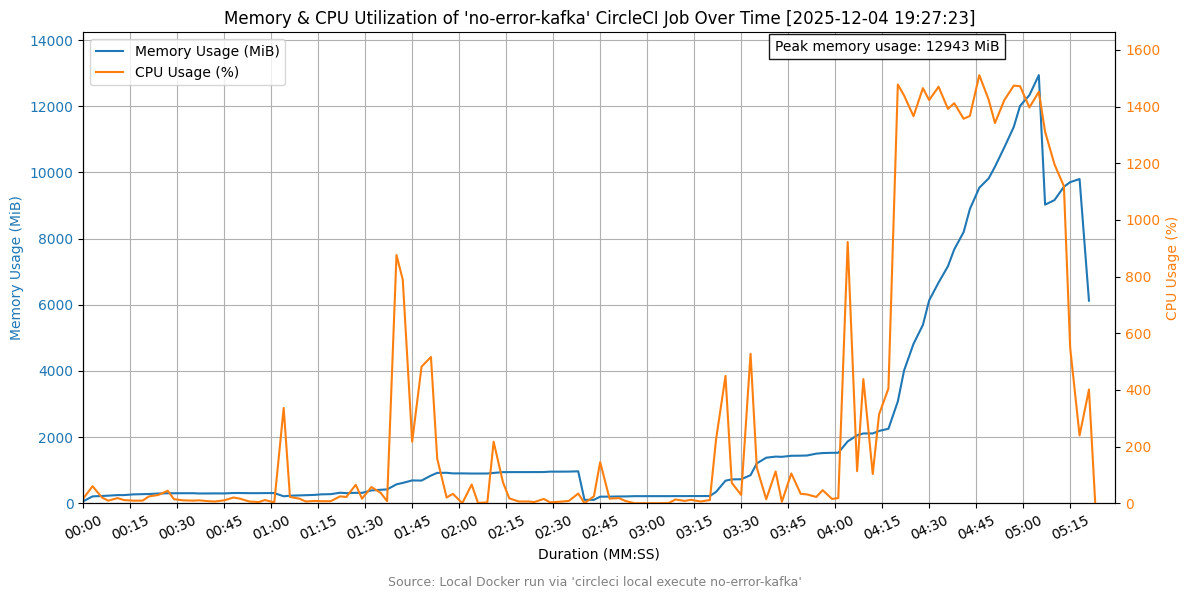

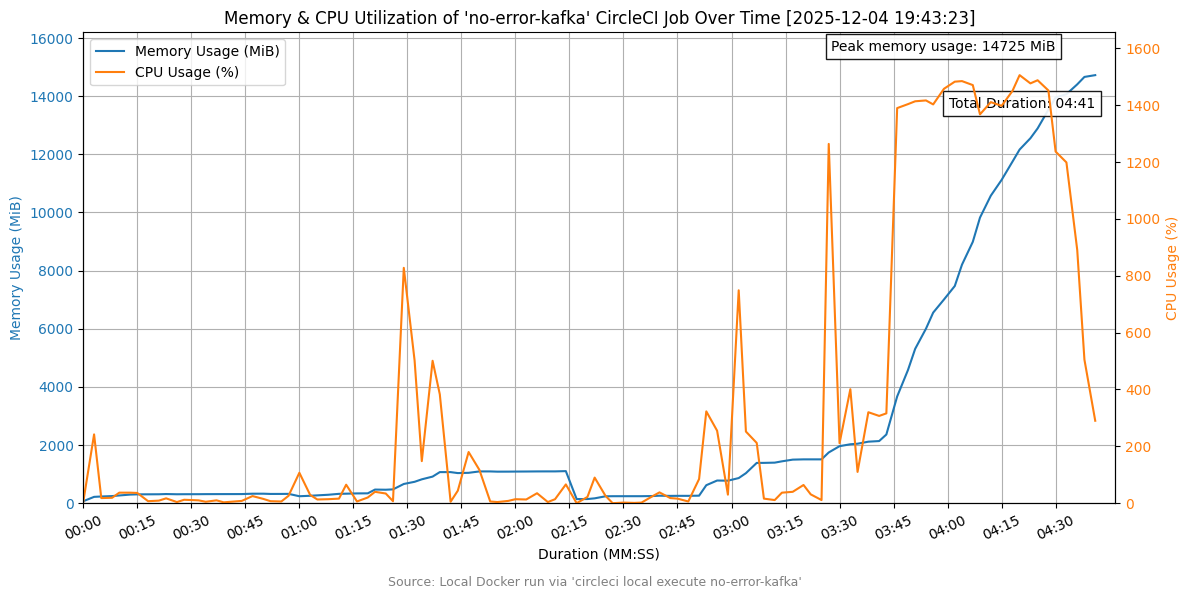

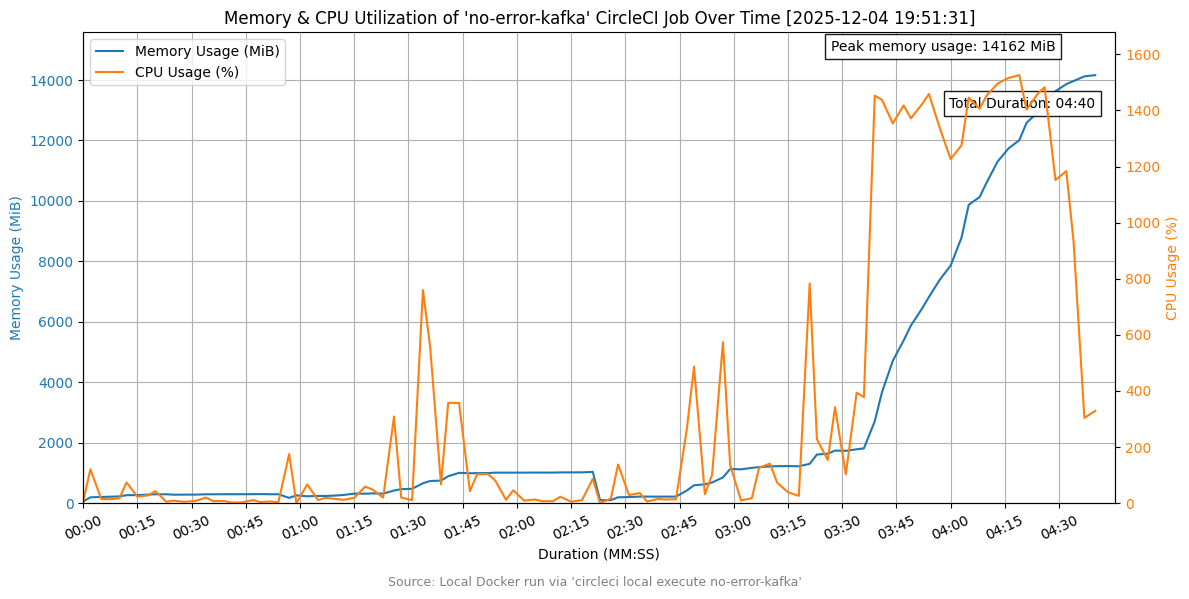

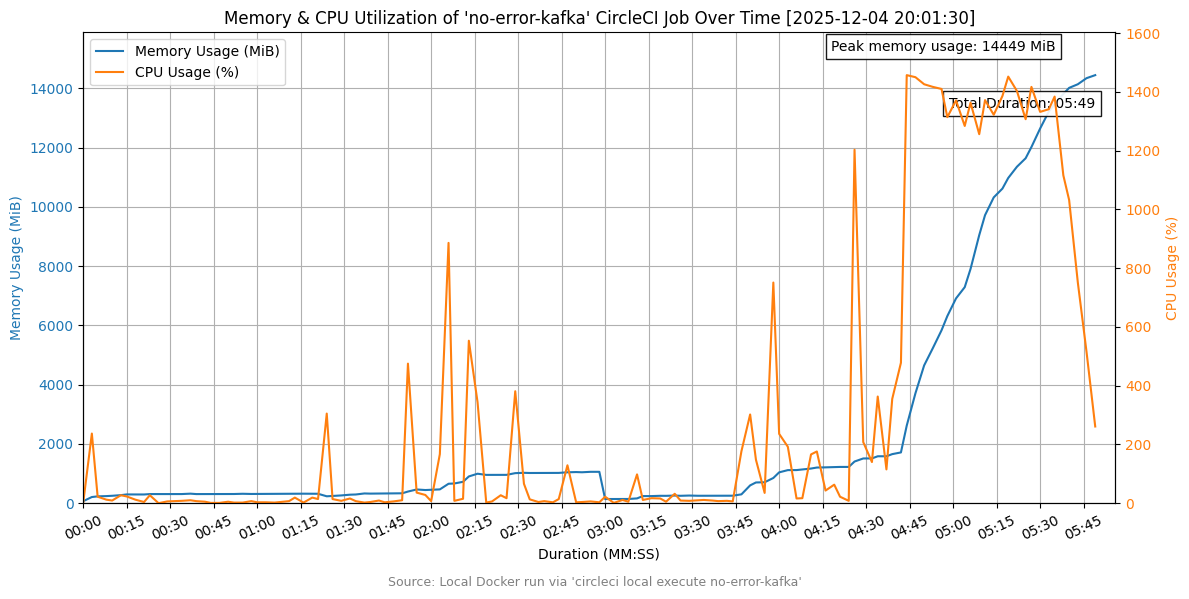

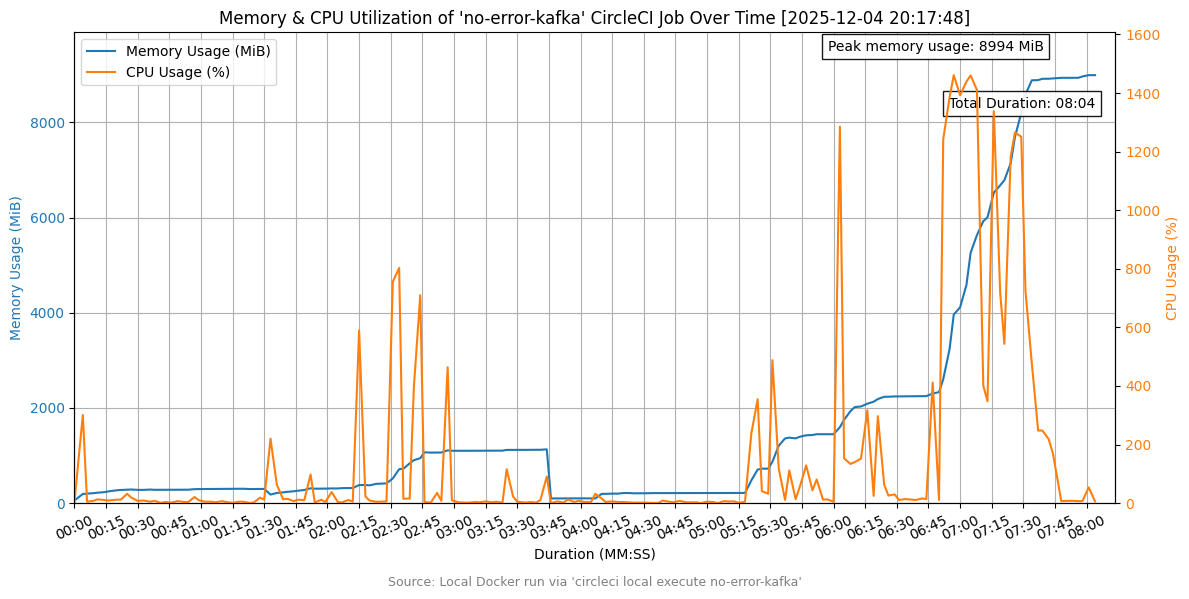

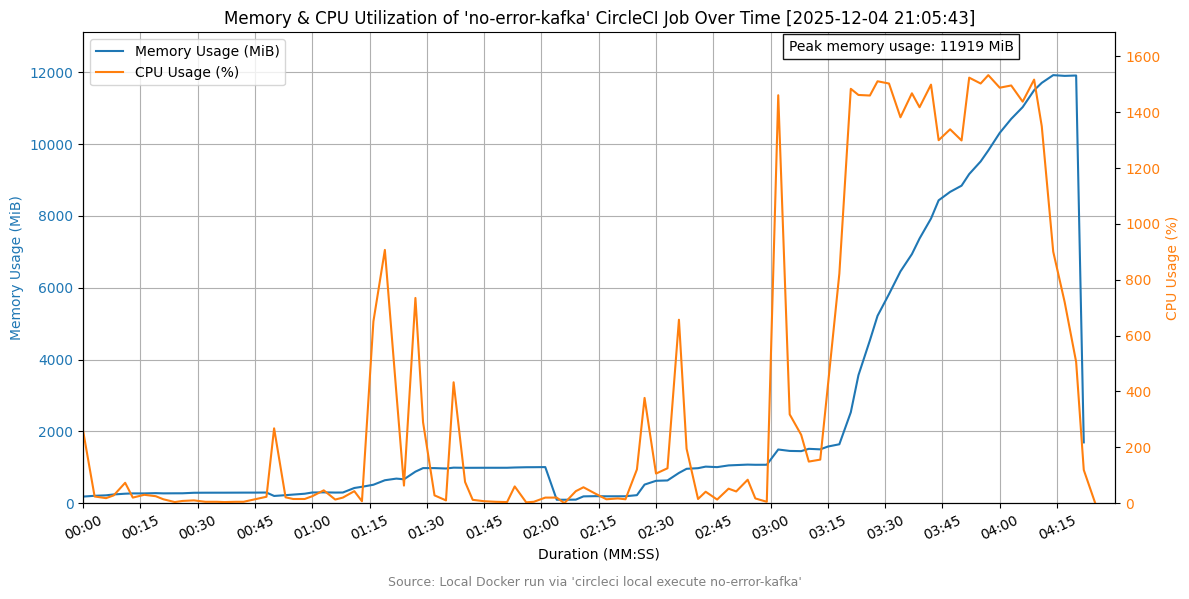

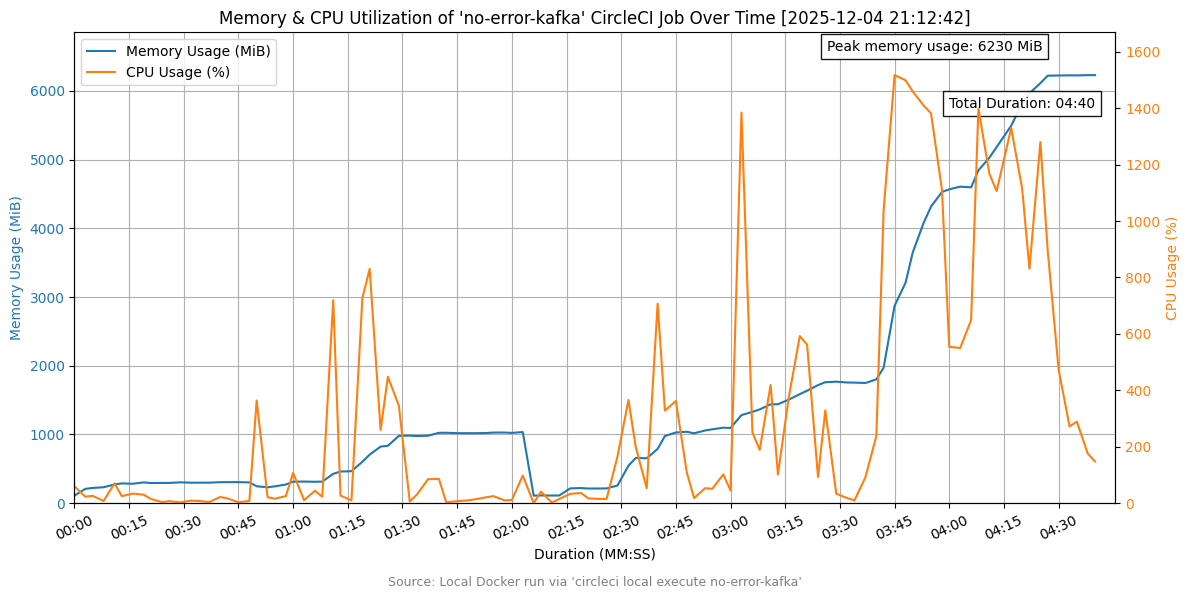

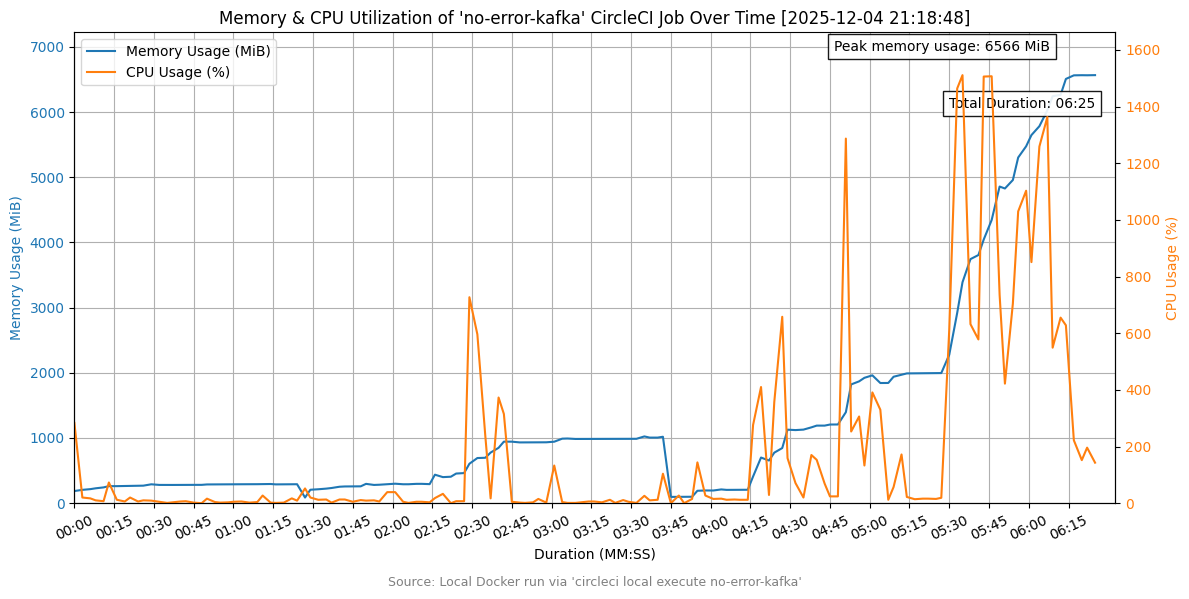

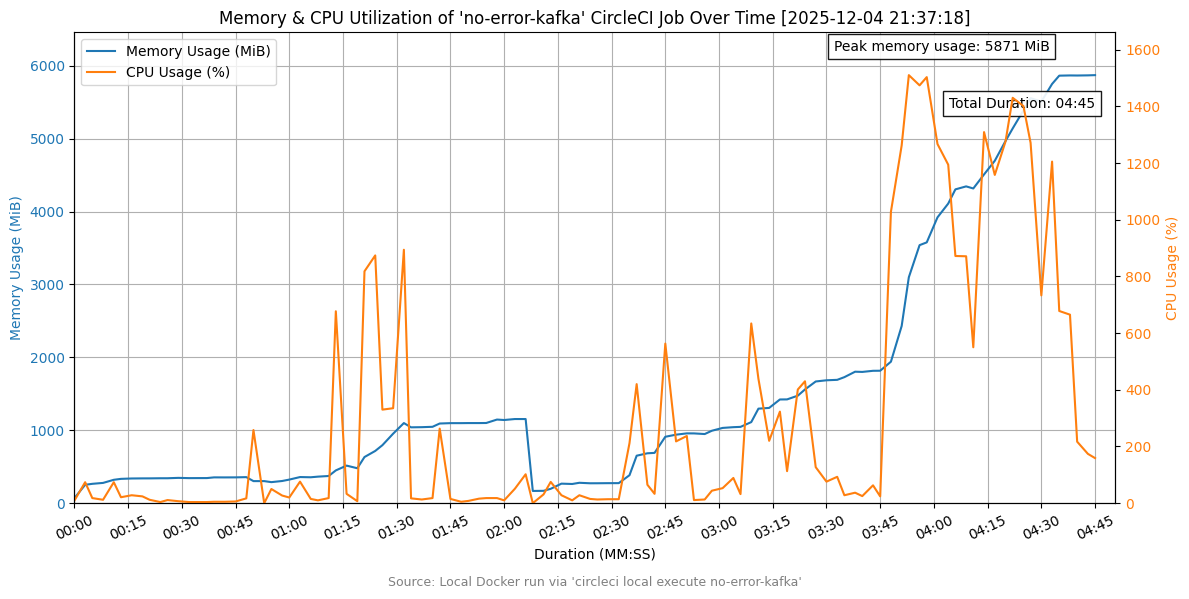

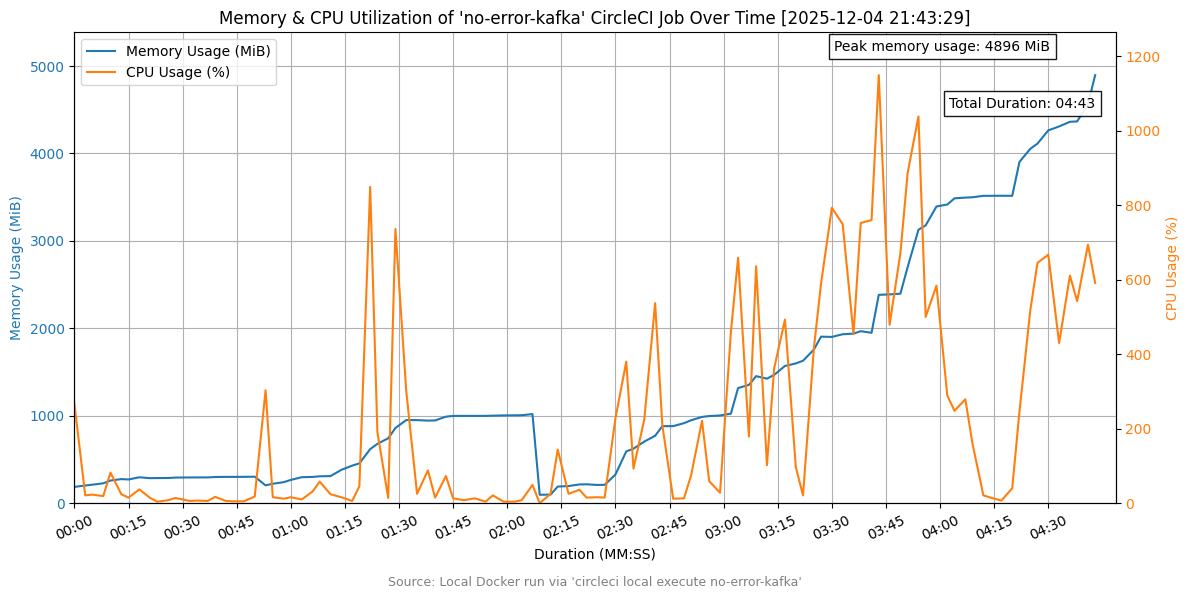

In [4]:
items = sorted(os.listdir("archives"))
for dir_name in items:
    dir_path = os.path.join("archives", dir_name)
    if not os.path.isdir(dir_path):
        continue
    csv_path = os.path.join(dir_path, "docker-stats.csv")
    if not os.path.exists(csv_path) or not os.path.isfile(csv_path):
        continue

    df = pd.read_csv(csv_path, parse_dates=['timestamp'])
    df["mem_usage_mib"] = df["mem_usage"].apply(convert_mem_to_mib)
    start_time = df["timestamp"].iloc[0]
    df["elapsed_seconds"] = (df["timestamp"] - start_time).dt.total_seconds()
    df["elapsed_mm_ss"] = df["elapsed_seconds"].apply(lambda s: f"{int(s//60):02d}:{int(s%60):02d}")
    df["cpu_perc"] = df["cpu_perc"].str.rstrip('%').replace(r'\.[0-9]+', '', regex=True).astype(int)
    
    timestamp = dir_name[:4] \
                    + "-" + dir_name[4:6] \
                    + "-" + dir_name[6:8] \
                    + " " + dir_name[9:11] \
                    + ":" + dir_name[12:14] \
                    + ":" + dir_name[15:17]
    create_png_visualization(df, os.path.join(dir_path, "performance-plot.png"), timestamp)